#### Single Trial Analysis 
##### New Bonsai NWBs

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import codeocean
from codeocean import CodeOcean 
import sys 
import pandas as pd
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from datetime import datetime
from pathlib import Path 
from typing import Union, List, Optional



import joblib
from joblib import Memory
import re
import glob

from aind_dynamic_foraging_data_utils import nwb_utils as nu
import aind_dynamic_foraging_basic_analysis.licks.annotation as a

sys.path.insert(1, '/root/capsule/code/utils')
import behavior_utils as bu
import array_utils as au
import data_utils as du 
import nwb_utils

In [2]:
data_folder = '/root/capsule/data/'
behavior_folder = '/root/capsule/data/foraging_nwb_bonsai'
master_df_path = '/root/capsule/data/df_processed_20241025.csv'

In [13]:
# No processed_CO_dataID, session_names

master_df = pd.read_csv(master_df_path)
filtered_df = du.filter_fiber_probes(master_df)
data_asset_IDs = du.get_processed_CO_dataID_for_stage(filtered_df, stage = 'STAGE_3')
session_names = du.get_processed_session_name_for_stage(filtered_df, stage = 'STAGE_3')
nwb_suffixes = du.get_nwb_suffix_for_stage(filtered_df, stage = 'STAGE_3')
formatted_suffixes = du.format_nwb_suffixes(nwb_suffixes)

In [14]:
data_assets = du.generate_data_asset_params(data_asset_IDs, mount_point=None)
token = os.getenv('CUSTOM_KEY')
client = CodeOcean(domain="https://codeocean.allenneuraldynamics.org", token=token)
capsule_id = "6a9f6065-d87a-40ce-831d-0676a2a4a835"
results = client.capsules.attach_data_assets(
    capsule_id=capsule_id,
    attach_params=data_assets,
)

In [34]:
nwb_fib = nu.load_nwb_from_filename(data_folder + 
'behavior_700708_2024-06-20_09-14-58_processed_2024-06-28_23-35-30/nwb/behavior_700708_2024-06-20_09-14-58.nwb')

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [35]:
nwb_fib

,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_power,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.397235e+07,1.397235e+07,1.0,False,True,1.397235e+07,1.397235e+07,1.397235e+07,False,True,0.8,0.0,0.8,0.010383,0.511088,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.447869,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
1,1.397235e+07,1.397236e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397236e+07,False,False,0.8,0.0,0.8,0.652389,0.961181,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,2.244803,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.0,3097.0,2.0,2.0
2,1.397236e+07,1.397237e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397237e+07,False,False,0.8,0.0,0.8,0.349353,0.896613,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.255656,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
3,1.397237e+07,1.397238e+07,0.0,False,False,1.397237e+07,1.397237e+07,1.397238e+07,False,True,0.8,0.0,0.8,0.143479,0.239877,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,5.630439,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_power,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.397235e+07,1.397235e+07,1.0,False,True,1.397235e+07,1.397235e+07,1.397235e+07,False,True,0.8,0.0,0.8,0.010383,0.511088,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.447869,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
1,1.397235e+07,1.397236e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397236e+07,False,False,0.8,0.0,0.8,0.652389,0.961181,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,2.244803,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.0,3097.0,2.0,2.0
2,1.397

In [36]:
fib_df = nwb_utils.create_fib_df(nwb_fib)
fib_df

,timestamps,data,event
0,-721.676768,1.000000,FIP_rising_time
1,-721.661408,1.000000,FIP_falling_time
2,-721.626752,1.000000,FIP_rising_time
3,-721.611392,1.000000,FIP_falling_time
4,-721.576768,1.000000,FIP_rising_time
...,...,...,...
697859,4349.438400,520.621762,Iso_1
697860,4349.537216,522.694301,Iso_1
697861,4349.537216,326.057013,Iso_2
697862,4349.539616,326.348917,Iso_2


##### behavior level analysis

In [17]:
cachedir = '/root/capsule/scratch'
memory = Memory(cachedir, verbose=0)

@memory.cache
def load_nwb_files(base_dir: str, ignore_dirs: Optional[List[str]] = None, process_data: bool = True) -> Union[dict, List]:
    """ 
    Load NWB files from base directory from prior loading in OC capsule (behavior_** subdirecories)

    Params: 
    base_dir (str): Base directory containing behavior sub folders and NWBs 
    process_data (bool) (optional: True -> create lick, trial, events DataFrames for each NWB 

    Returns: 
    Union[dict, List]: True -> Dictionary with NWB objects as values and paths as keys 
                       False -> List of paths to NWB files

    """ 

    # Convert to path object
    base_path = Path(base_dir)

    # Find all directories with regex behavior_** 
    behavior_dirs = list(base_path.glob('behavior_*'))

    if ignore_dirs:
        behavior_dirs = [d for d in behavior_dirs if d.name not in ignore_dirs]

    if not behavior_dirs:
        raise ValueError(f'No behavior files found in {base_dir}')

    # Find all NWB files in subdirectories 
    nwb_files = []
    for behavior_dir in behavior_dirs:
        nwb_path = behavior_dir / 'nwb'
        if nwb_path.exists():
            nwb_files.extend(list(nwb_path.glob('*.nwb')))

    if not nwb_files:
        raise ValueError(f'No .nwb files found in behavior folders')

    if not process_data:
        return [str(path) for path in nwb_files]

    # Load / process each NWB file
    processed_nwbs = {}
    for nwb_file in nwb_files:
        try:
            # Load NWB file 
            nwb = nu.load_nwb_from_filename(str(nwb_file))

            # Process DataFrames
            nwb.df_trials = nu.create_df_trials(nwb)
            nwb.df_events = nu.create_events_df(nwb)
            nwb.df_licks = a.annotate_licks(nwb)

            processed_nwbs[str(nwb_file)] = nwb

        except Exception as e:
            print(f'Error processing {nwb_file}: {str(e)}')
            continue

    return processed_nwbs


In [ ]:
base_dir = '/root/capsule/data'
ignore_dirs = ['filtered_data_session', 'foraging_nwb_bonsai', 'foraging_nwb_bonsai_processed', 'df_processed_20241025.csv']
nwbs = load_nwb_files(base_dir, ignore_dirs = ignore_dirs)

In [22]:
nwb1 = nwbs[list(nwbs.keys())[0]]

nwb1.df_trials

,trial,animal_response,rewarded_historyL,rewarded_historyR,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,...,goCue_start_time_in_trial,reward_outcome_time_in_session,reward_outcome_time_in_trial,goCue_start_time_raw,reward_time_in_session,reward_time_in_trial,choice_time_in_session,choice_time_in_trial,earned_reward,extra_reward
0,0,2.0,False,False,True,False,0.8,0.8,0.0,0.002557,...,0.0,5.018752,5.018752,7.561707e+06,NaN,NaN,NaN,NaN,False,False
1,1,0.0,True,False,True,False,0.8,0.8,0.0,0.887021,...,0.0,9.220736,0.488640,7.561716e+06,9.332256,0.600160,9.221344,0.489248,True,False
2,2,2.0,False,False,True,False,0.8,0.8,0.0,0.492512,...,0.0,17.479744,5.013632,7.561720e+06,NaN,NaN,NaN,NaN,False,False
3,3,2.0,False,False,True,False,0.8,0.8,0.0,0.235265,...,0.0,27.596736,5.014848,7.561730e+06,NaN,NaN,NaN,NaN,False,False
4,4,0.0,True,False,True,False,0.8,0.8,0.0,0.342278,...,0.0,33.878752,0.979776,7.561740e+06,32.911232,0.012256,33.878912,0.979936,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,860,1.0,False,True,False,True,0.8,0.0,0.8,0.270904,...,0.0,4481.417728,0.112800,7.566189e+06,4481.520256,0.215328,4481.418496,0.113568,True,False
861,861,1.0,False,True,False,True,0.8,0.0,0.8,0.229112,...,0.0,4484.594752,0.323808,7.566192e+06,4484.704256,0.433312,4484.595776,0.324832,True,False
862,862,1.0,False,False,True,False,0.8,0.8,0.0,0.351920,...,0.0,4489.994752,0.306752,7.566197e+06,NaN,NaN,4489.995040,0.307040,False,False
863,863,1.0,False,False,True,False,0.8,0.8,0.0,0.558335,...,0.0,4493.004736,0.116704,7.566200e+06,NaN,NaN,4493.005344,0.117312,False,False


In [38]:
DATA_DIR = '/root/capsule/data/behavior_700708_2024-06-20_09-14-58_processed_2024-06-28_23-35-30/nwb/'
NWB_FILES = glob.glob(DATA_DIR+'**.nwb')

nwb = nu.load_nwb_from_filename(NWB_FILES[0])

# accepts either an NWB file, filepath, or list of filepaths
nwb.df_trials = nu.create_df_trials(nwb)
nwb.df_events = nu.create_events_df(nwb)
nwb.df_licks = a.annotate_licks(nwb)

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.9/site-packages/aind_dynamic_foraging_data_utils/nwb_utils.py:457: UserWarning: Reward before choice time. This is likely due to manual rewards
  warnings.warn("Reward before choice time. This is likely due to manual rewards")


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


In [39]:
# Check

DATA_DIR = '/root/capsule/data/behavior_757129_2024-09-19_09-53-24_processed_2024-10-07_16-29-19/nwb/'
NWB_FILES = glob.glob(DATA_DIR+'**.nwb')

new_nwb = nu.load_nwb_from_filename(NWB_FILES[0])

# accepts either an NWB file, filepath, or list of filepaths
new_nwb.df_trials = nu.create_df_trials(new_nwb)
new_nwb.df_events = nu.create_events_df(new_nwb)
new_nwb.df_licks = a.annotate_licks(new_nwb)

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


In [40]:
nwb

,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_power,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.397235e+07,1.397235e+07,1.0,False,True,1.397235e+07,1.397235e+07,1.397235e+07,False,True,0.8,0.0,0.8,0.010383,0.511088,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.447869,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
1,1.397235e+07,1.397236e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397236e+07,False,False,0.8,0.0,0.8,0.652389,0.961181,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,2.244803,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.0,3097.0,2.0,2.0
2,1.397236e+07,1.397237e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397237e+07,False,False,0.8,0.0,0.8,0.349353,0.896613,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.255656,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
3,1.397237e+07,1.397238e+07,0.0,False,False,1.397237e+07,1.397237e+07,1.397238e+07,False,True,0.8,0.0,0.8,0.143479,0.239877,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,5.630439,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_power,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.397235e+07,1.397235e+07,1.0,False,True,1.397235e+07,1.397235e+07,1.397235e+07,False,True,0.8,0.0,0.8,0.010383,0.511088,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.447869,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
1,1.397235e+07,1.397236e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397236e+07,False,False,0.8,0.0,0.8,0.652389,0.961181,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,2.244803,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.0,3097.0,2.0,2.0
2,1.397

In [41]:
print(nwb.df_trials.shape)
nwb.df_trials.head()

(651, 73)


,trial,animal_response,rewarded_historyL,rewarded_historyR,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,...,goCue_start_time_in_trial,reward_outcome_time_in_session,reward_outcome_time_in_trial,goCue_start_time_raw,reward_time_in_session,reward_time_in_trial,choice_time_in_session,choice_time_in_trial,earned_reward,extra_reward
0,0,1.0,False,True,False,True,0.8,0.0,0.8,0.010383,...,0.0,2.708640,2.708640,1.397235e+07,2.720128,2.720128,2.709440,2.709440,True,False
1,1,0.0,False,False,False,False,0.8,0.0,0.8,0.652389,...,0.0,10.244640,3.981696,1.397236e+07,NaN,NaN,10.244960,3.982016,False,False
2,2,0.0,False,False,False,False,0.8,0.0,0.8,0.349353,...,0.0,17.053632,2.257728,1.397236e+07,NaN,NaN,17.054400,2.258496,False,False
3,3,0.0,False,False,False,True,0.8,0.0,0.8,0.143479,...,0.0,26.637632,2.658816,1.397237e+07,NaN,NaN,26.638112,2.659296,False,False
4,4,2.0,False,False,False,True,0.8,0.0,0.8,0.842703,...,0.0,38.993632,5.014560,1.397238e+07,NaN,NaN,NaN,NaN,False,False


In [43]:
nwb.trials.animal_response.description

'The response of the animal. 0, left choice; 1, right choice; 2, no response'

In [44]:
# Probability chosen metric calculation 

def calculate_probabilities(row):
    # No response results in a NaN value
    if row.animal_response == 2:
        return np.nan, np.nan
    # Chosen = left choice left probability, not chosen = left choice right probability 
    elif row.animal_response == 0:
        return row.reward_probabilityL, row.reward_probabilityR
    else: # Chosen = right choice right probability, not chosen = right choice left probability 
        return row.reward_probabilityR, row.reward_probabilityL


In [52]:
def chosen_metric(df):
    # Calculate the difference for each row
    average = (df['probability_chosen'] - df['probability_not_chosen'])
    
    # Find global maximum
    p_larger_global = max(df['probability_chosen'].max(), df['probability_not_chosen'].max())
    
    # Find global minimum
    p_smaller_global = min(df['probability_chosen'].min(), df['probability_not_chosen'].min())
    
    # Calculate mean of the differences
    mean_difference = average.mean()
    
    # Calculate final metric
    final_metric = mean_difference / (p_larger_global - p_smaller_global)
   
    print(final_metric)

In [53]:
nwb.df_trials['probability_chosen'], nwb.df_trials['probability_not_chosen'] = zip(*nwb.df_trials.apply(calculate_probabilities, axis=1))

chosen_metric(nwb.df_trials)

0.23659305993690852


In [54]:
sample_df = nwb.df_trials.loc[:, ['trial', 'animal_response', 'reward_probabilityL', 'reward_probabilityR', 'probability_chosen', 'probability_not_chosen']]
sample_df.head()

,trial,animal_response,reward_probabilityL,reward_probabilityR,probability_chosen,probability_not_chosen
0,0,1.0,0.0,0.8,0.8,0.0
1,1,0.0,0.0,0.8,0.0,0.8
2,2,0.0,0.0,0.8,0.0,0.8
3,3,0.0,0.0,0.8,0.0,0.8
4,4,2.0,0.0,0.8,NaN,NaN


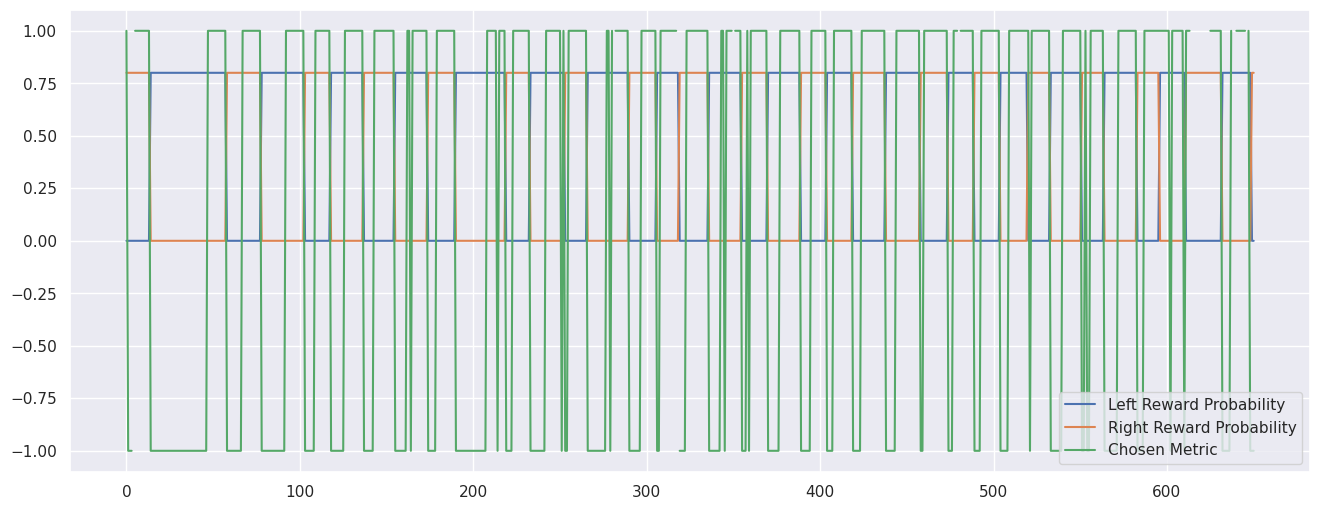

In [ ]:
reward_left = nwb.df_trials.reward_probabilityL.tolist()
reward_right = nwb.df_trials.reward_probabilityR.tolist()

chosen_metric = sample_df['chosen_metric'].tolist()

x = np.arange(0, len(sample_df['trial']))

y = reward_left
y1 = reward_right
y2 = chosen_metric

plt.figure(figsize=(16,6))
plt.plot(x, y, label='Left Reward Probability')
plt.plot(x, y1, label='Right Reward Probability')
plt.plot(x, y2, label='Chosen Metric') 
plt.legend()

plt.show()

In [49]:
data = {
    'trial': [0, 1, 2, 3, 4],
    'animal_response': [1.0, 0.0 , 0.0, 0.0, 2.0],
    'reward_probabilityL': [0.0, 0.0, 0.0, 0.0, 0.0],
    'reward_probabilityR': [0.8, 0.8, 0.8, 0.8, 0.8]
}

test_df = pd.DataFrame(data)

test_df

,trial,animal_response,reward_probabilityL,reward_probabilityR
0,0,1.0,0.0,0.8
1,1,0.0,0.0,0.8
2,2,0.0,0.0,0.8
3,3,0.0,0.0,0.8
4,4,2.0,0.0,0.8


In [55]:
test_df['probability_chosen'], test_df['probability_not_chosen'] = zip(*test_df.apply(calculate_probabilities, axis=1))

test_df

,trial,animal_response,reward_probabilityL,reward_probabilityR,probability_chosen,probability_not_chosen
0,0,1.0,0.0,0.8,0.8,0.0
1,1,0.0,0.0,0.8,0.0,0.8
2,2,0.0,0.0,0.8,0.0,0.8
3,3,0.0,0.0,0.8,0.0,0.8
4,4,2.0,0.0,0.8,NaN,NaN


In [56]:
chosen_metric(test_df)

-0.5
